# Run Segment Anything Model 2 on a live video stream


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython import display
import networkx as nx
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import re

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 camera predictor


In [3]:
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint) # in multiple object tracking we have initialise interference state

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_bbox(bbox, ax, marker_size=200):
    tl, br = bbox[0], bbox[1]
    w, h = (br - tl)[0], (br - tl)[1]
    x, y = tl[0], tl[1]
    print(x, y, w, h)
    ax.add_patch(plt.Rectangle((x, y), w, h, fill=None, edgecolor="blue", linewidth=2))

In [5]:
def gen_out_mask_logits_ids(ann_frame_idx=0, ann_obj_id=1, points=None,  bbox=None, mask=None, labels=None):
    if points is not None:
        if labels is None:
            raise ValueError("Labels must be provided if points are given.")
        else:
            _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
                frame_idx=ann_frame_idx,
                obj_id=ann_obj_id,
                points=points,
                labels=labels,
            )
            # show_points(points, labels, plt.gca())

    elif bbox is not None:
        # TODO need to add multiple prompt per track
        _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
            frame_idx=ann_frame_idx, obj_id=ann_obj_id, bbox=bbox)
        # show_bbox(bbox, plt.gca())

    elif mask is not None:
        # mask_img_path="masks/aquarium/aquarium_mask.png"
        # mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)
        # mask = mask / 255
        assert mask.max() <= 1 , "Masks should be in [0, 1] range."
        _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
            frame_idx=ann_frame_idx, obj_id=ann_obj_id, mask=mask
        )
        # show_mask(out_mask_logits, plt.gca(), obj_id=ann_obj_id, random_color=True)
    else:
        raise ValueError("At least one of points, bbox, or mask must be provided.")
    
    return out_obj_ids, out_mask_logits

#### Select an video stream (video or camera)


In [6]:
cap = cv2.VideoCapture("videos/aquarium/aquarium.mp4")
cap = cv2.VideoCapture("/scratch3/kat049/datasets/DARPA/p14_fr/camera0-1024x768-002.mp4")
ret, frame = cap.read()
width, height = frame.shape[:2][::-1]

start_idx = 1148
vis_gap = 30
video_dir = "/scratch3/kat049/datasets/DARPA/p14_fr/results" #args.video_path
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(p[len("frame"):].split('.')[0]))
frame_names = frame_names[start_idx:-1:vis_gap]
frame = Image.open(os.path.join(video_dir, frame_names[0])) #image_pil
frame_RGB = np.array(frame) #image_rgb
frame_BGR = frame_RGB[:, :, ::-1]  # image
width, height = frame.size[0], frame.size[1]

#### Step 1: Add a first click on the first frame


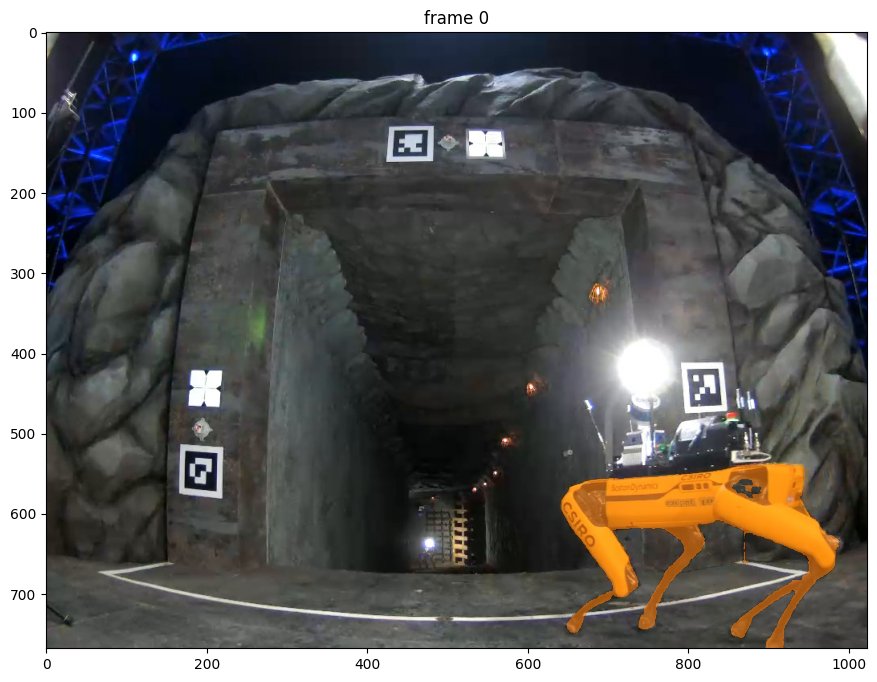

In [7]:
predictor.load_first_frame(frame_BGR)
# if_init = True

# using_point = False # if True, we use point prompt
# using_box = True # if True, we use point prompt
# using_mask= False  # if True, we use mask prompt

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    1  # give a unique id to each object we interact with (it can be any integers)
)
# Let's add a positive click at (x, y) = (210, 350) to get started

# using point prompt
points = np.array([[670, 247]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], dtype=np.int32)
bbox = np.array([[600, 214], [765, 286]], dtype=np.float32)
bbox = np.array([[440, 580], [500, 680]], dtype=np.float32)
bbox1 = np.array([[620, 540], [980, 800]], dtype=np.float32)
# bbox2 = np.array([[160, 510], [220, 580]], dtype=np.float32)


# # TODO need to implement multiple prompt per track
# bboxes = [bbox1, bbox2]
# for ann_obj_id in range(2):
#     print(f"Adding prompt for object {ann_obj_id+1} in frame {ann_frame_idx} with bbox {bboxes[ann_obj_id]}")
#     # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     plt.figure(figsize=(12, 8))
#     plt.title(f"frame {ann_frame_idx}")
#     plt.imshow(frame_RGB)
#     bbox = bboxes[ann_obj_id]
#     out_obj_ids, out_mask_logits = gen_out_mask_logits_ids(
#         ann_frame_idx=ann_frame_idx,
#         ann_obj_id=ann_obj_id+1,
#         points=None,
#         labels=None,
#         bbox=bbox,
#         mask=None,
#     )
#     show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id+1)
#     plt.show()
#     plt.close()

# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame_RGB)
out_obj_ids, out_mask_logits = gen_out_mask_logits_ids(
    ann_frame_idx=ann_frame_idx,
    ann_obj_id=ann_obj_id,
    points=None,
    labels=None,
    bbox=bbox1,
    mask=None,
)
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)
plt.show()


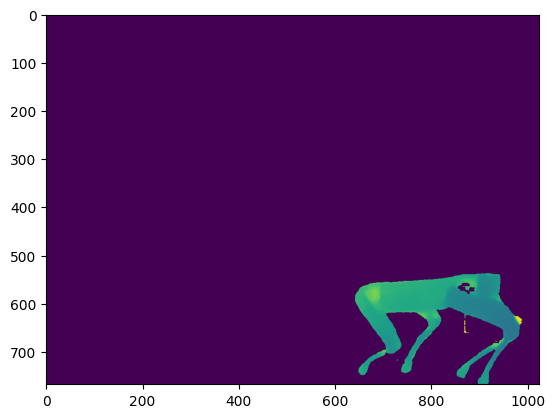

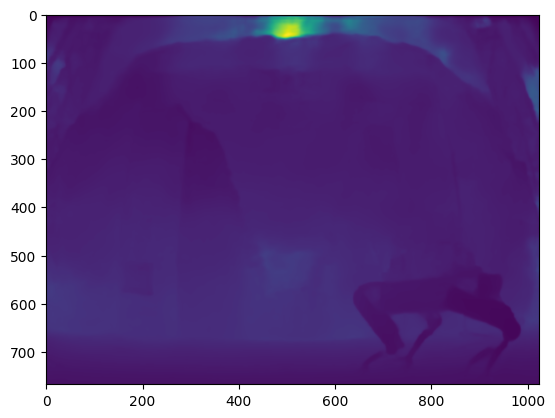

5.5566872775532365

In [8]:
# depth_names = [
#     p for p in os.listdir(video_dir)
#     if os.path.splitext(p)[-1] in [".png"]
# ]
# depth_names.sort(key=lambda p: int(p[len("depth"):].split('.')[0]))
# depth_names = depth_names[start_idx:-1:vis_gap]

depth_frame = Image.open(os.path.join(video_dir, re.sub(r'frame(\d+)\.jpg', r'depth\1.png', frame_names[0]))) #image_pil
depth_frame = np.array(depth_frame)

mask = (out_mask_logits.squeeze() > 0).cpu().numpy()  # Shape: (768, 1024)
masked_depth_image = depth_frame * mask  # Shape: (768, 1024)
masked_depths = depth_frame[mask]
plt.imshow(masked_depth_image)
plt.show()
plt.imshow(depth_frame)
plt.show()
mean_depth = np.mean(masked_depths)/1000 # Convert to meters
mean_depth

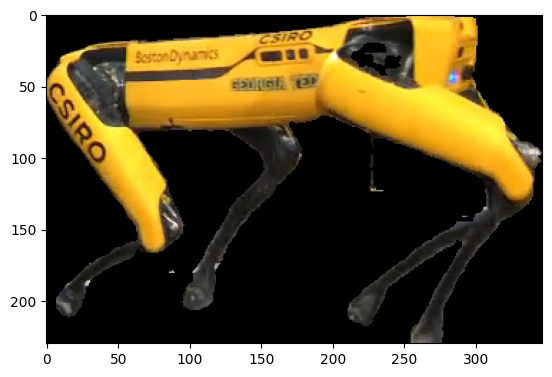

In [9]:
# get the masked image
masked_image = torch.tensor(frame_RGB.copy(), device="cuda").permute(2, 0, 1)  # [3, 360, 800]
# masked_rgb_image = frame_RGB * mask[..., None] 
# bbox = bbox1
# x_min, y_min = int(bbox[0][0]), int(bbox[0][1])
# x_max, y_max = int(bbox[1][0]), int(bbox[1][1])
# x_min = max(0, min(x_min, width-1))
# y_min = max(0, min(y_min, height-1))
# x_max = max(0, min(x_max, width-1))
# y_max = max(0, min(y_max, height-1))
# bbox_region = masked_image[:, y_min:y_max, x_min:x_max]
# bbox_region_np = bbox_region.permute(1, 2, 0).cpu().numpy()

rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)
y_min, y_max = np.where(rows)[0][[0, -1]]
x_min, x_max = np.where(cols)[0][[0, -1]]

# Crop both RGB and mask to bounding box
cropped_rgb = frame_RGB[y_min:y_max+1, x_min:x_max+1]
cropped_mask = mask[y_min:y_max+1, x_min:x_max+1]

masked_rgb_cropped = cropped_rgb * cropped_mask[:, :, None]
plt.imshow(masked_rgb_cropped)

In [ ]:
def create_mixed_graph(image_node, rel_distance):
    """Create a graph with mixed node types"""
    G = nx.Graph()
    
    # Add nodes with different types
    G.add_node("text1", type="text", content="Self", pos=(0, 0))
    G.add_node("mask1", type="mask", content=image_node, pos=(1, 1))
    
    # Add edges
    G.add_edges_from([
        ("text1", "mask1", {"weight": rel_distance}),
    ])
    
    return G

def visualize_mixed_graph(G, ax):
    """Visualize graph with text and image nodes"""    
    # Get positions
    pos = nx.get_node_attributes(G, 'pos')

    # Draw edges with weights
    edges = G.edges(data=True)
    edge_weights = [d.get('weight', 1.0) for u, v, d in edges]
    
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=2)
    
    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d.get('weight', 1.0):.1f}" for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, ax=ax, font_size=8)
    
    # Process each node
    for node, (x, y) in pos.items():
        node_data = G.nodes[node]
        
        if node_data['type'] == 'text':
            # Draw text nodes as boxes
            bbox = dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.8)
            ax.text(x, y, node_data['content'], ha='center', va='center', 
                   fontsize=12, bbox=bbox, weight='bold')
                   
        elif node_data['type'] == 'mask':
            # Draw mask nodes as images
            mask_img = node_data['content']
            # Handle different mask formats
            if len(mask_img.shape) == 2:
                # Grayscale mask [h, w] -> RGB
                mask_rgb = cv2.cvtColor(mask_img, cv2.COLOR_GRAY2RGB)
            elif mask_img.shape[2] == 3:
                # Already RGB [h, w, 3]
                mask_rgb = mask_img
            else:
                # Handle other cases (like RGBA)
                mask_rgb = mask_img[:, :, :3]
                
            # Create OffsetImage
            imagebox = OffsetImage(mask_rgb, zoom=0.5)
            ab = AnnotationBbox(imagebox, (x, y), frameon=True, pad=0.1)
            ax.add_artist(ab)
    
    # ax.set_xlim(-1, 3)
    # ax.set_ylim(-2, 2)
    # ax.set_aspect('equal')
    # ax.set_title('Graph at time', fontsize=14, weight='bold')
    ax.axis('off')
    
    # plt.tight_layout()
    # return ax

G_temporal = []
G = create_mixed_graph(masked_rgb_cropped,mean_depth)
G_temporal.append(G)

In [17]:
# fig, ax = plt.subplots(figsize=(12, 8))
# visualize_mixed_graph(G, ax)
# plt.show()
# plt.close(fig)
for i, file in enumerate(frame_names[1:]):
    if i > 30:
        break
    frame = Image.open(os.path.join(video_dir, file)) #image_pil
    frame_RGB = np.array(frame) #image_rgb
    frame_BGR = frame_RGB[:, :, ::-1]  # image

    out_obj_ids, out_mask_logits = predictor.track(frame_BGR)

    depth_frame = Image.open(os.path.join(video_dir, re.sub(r'frame(\d+)\.jpg', r'depth\1.png', file))) #image_pil
    depth_frame = np.array(depth_frame)

    mask = (out_mask_logits.squeeze() > 0).cpu().numpy()  # Shape: (768, 1024)
    masked_depth_image = depth_frame * mask  # Shape: (768, 1024)
    masked_depths = depth_frame[mask]
    # plt.imshow(masked_depth_image)
    # plt.show()
    # plt.imshow(depth_frame)
    # plt.show()
    mean_depth = np.mean(masked_depths)/1000 # Convert to meters
    # print(mean_depth)

    masked_image = torch.tensor(frame_RGB.copy(), device="cuda").permute(2, 0, 1)  # [3, h, w]
    print(i, (mask==True).any())
    if not (mask==True).any():
        print("No mask found, skipping frame")
        continue
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]

    # Crop both RGB and mask to bounding box
    cropped_rgb = frame_RGB[y_min:y_max+1, x_min:x_max+1]
    cropped_mask = mask[y_min:y_max+1, x_min:x_max+1]

    masked_rgb_cropped = cropped_rgb * cropped_mask[:, :, None]
    # plt.imshow(masked_rgb_cropped)

    G = create_mixed_graph(masked_rgb_cropped,mean_depth)
    G_temporal.append(G)
    # fig, ax = plt.subplots(figsize=(12, 8))
    # visualize_mixed_graph(G, ax)
    # plt.show()
    # plt.close(fig)

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 False
No mask found, skipping frame
22 False
No mask found, skipping frame


/scratch3/kat049/segment-anything-2-real-time/.venv2/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scratch3/kat049/segment-anything-2-real-time/.venv2/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


23 False
No mask found, skipping frame
24 False
No mask found, skipping frame
25 False
No mask found, skipping frame
26 False
No mask found, skipping frame
27 False
No mask found, skipping frame
28 False
No mask found, skipping frame
29 False
No mask found, skipping frame
30 False
No mask found, skipping frame


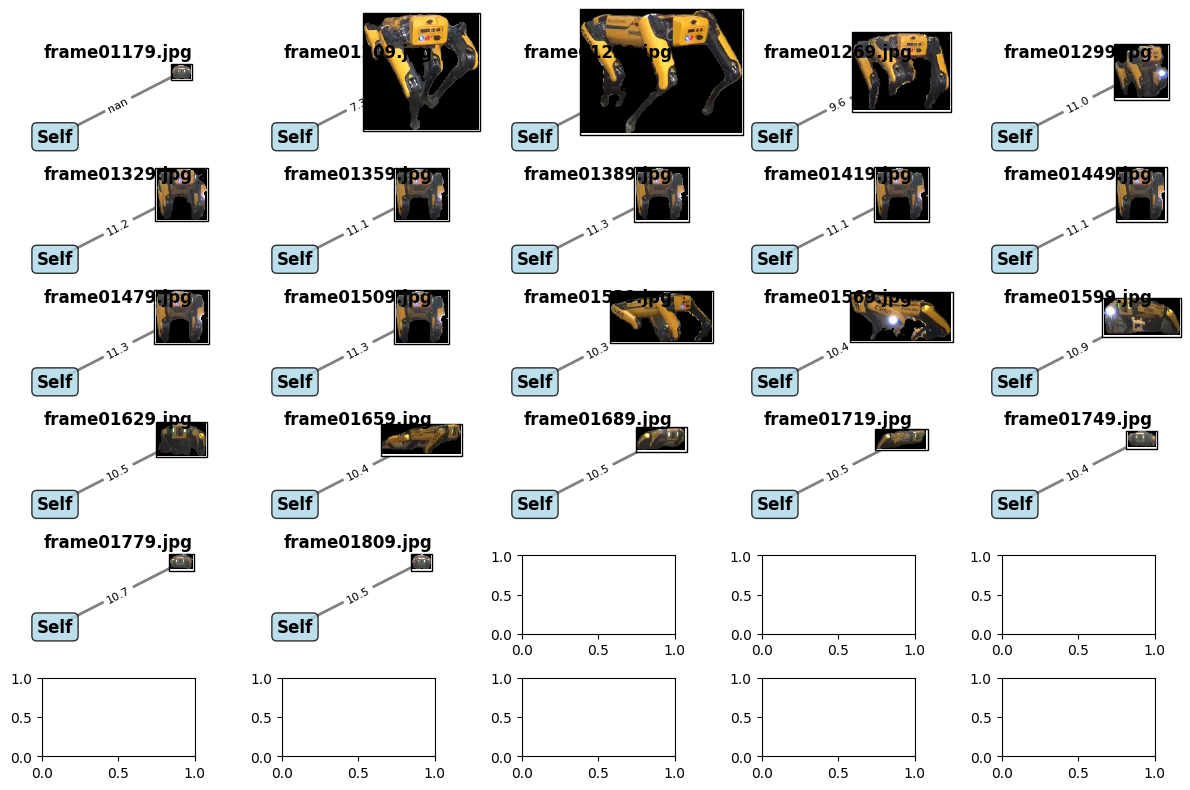

In [19]:
fig, axes  = plt.subplots(6, 5, figsize=(12, 8))
ax_iter = iter(axes.flat)


for i, g in enumerate(G_temporal):
    file = frame_names[1:][i]
    try:
        ax = next(ax_iter)
        visualize_mixed_graph(g, ax=ax)
        ax.set_title(f'{file}', fontsize=12, weight='bold')
    except StopIteration:
        print(f"Warning: More graphs ({len(G_temporal)}) than subplots (12)")
        break

# Hide unused subplots
for j in range(i+1, 12):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()